In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweet_df = pd.read_csv('/content/train.csv')


In [ ]:
tweet_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
# printing random tweets
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 

  bihday your majesty 

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   

 factsguide: society now    #motivation 



In [ ]:
#creating a function to process the data
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [ ]:
import nltk
nltk.download('punkt')        # Tokenizer models
nltk.download('stopwords')    # Stopwords list


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tweet_df = tweet_df.drop_duplicates('tweet')

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

# Downloading necessary resources
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the lemmatizing function
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data.split()]  # Ensure it's a string and split it into words
    return " ".join(tweet)  # Return the lemmatized tweet as a string

# Apply the function to the DataFrame
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))

In [ ]:
# printing the data to see the effect of preprocessing
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

@user when a father is dysfunctional and is so selfish he drag his kid into his dysfunction. #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair van in pdx. #disapointed #getthanked 

bihday your majesty 

#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦ 

factsguide: society now #motivation 



In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29530 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29530 non-null  int64 
 1   label   29530 non-null  int64 
 2   tweet   29530 non-null  object
dtypes: int64(2), object(1)
memory usage: 922.8+ KB


In [ ]:
tweet_df['label'].value_counts()

,count
label,
0,27517
1,2013


### Data visualization

<Axes: xlabel='label', ylabel='count'>

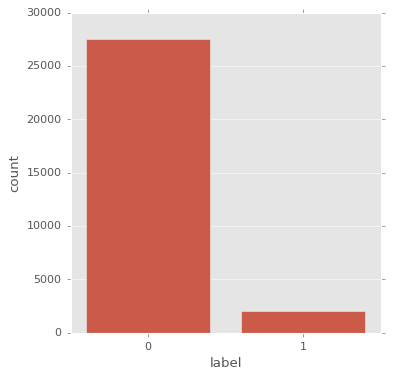

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = tweet_df)

Text(0.5, 1.0, 'Distribution of sentiments')

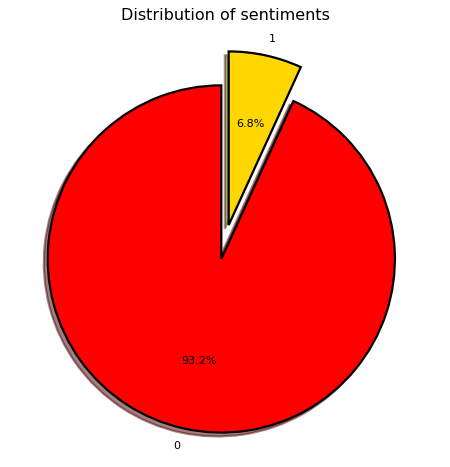

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_df['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90,
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [ ]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
non_hate_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation


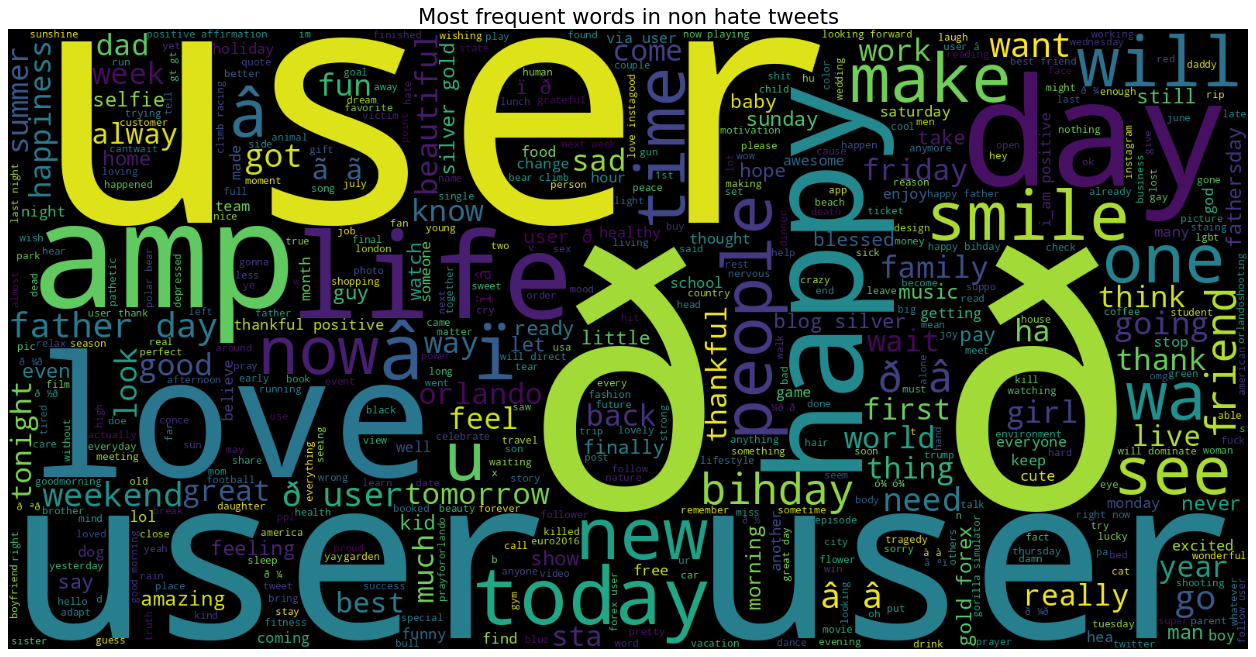

In [ ]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non hate tweets', fontsize = 19)
plt.show()

In [ ]:
neg_tweets = tweet_df[tweet_df.label == 1]
neg_tweets.head()

,id,label,tweet
13,14,1,@user #cnn call #michigan middle school 'build...
14,15,1,no comment! in #australia #opkillingbay #seash...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy say i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


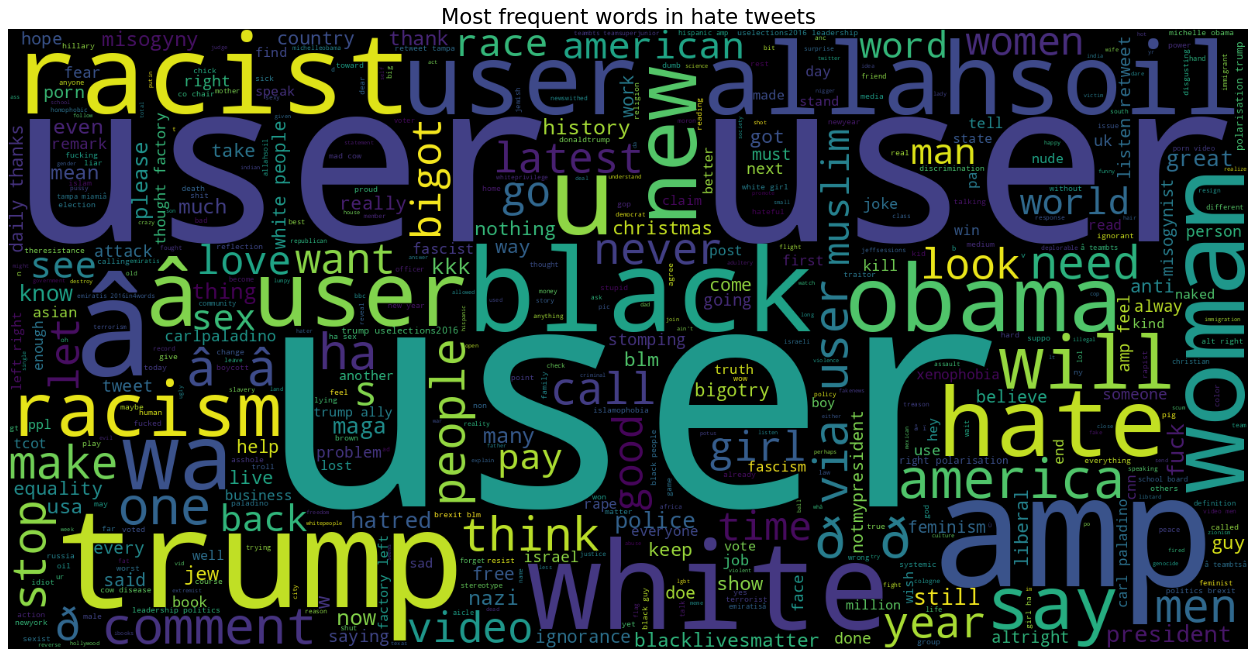

In [ ]:
text = ' '.join([word for word in neg_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize = 19)
plt.show()

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))


Number of features: 224971

First 20 features: 
['00' '00 35' '00 and' '00 blog' '00 drop' '00 folkmusic' '00 from'
 '00 get' '00 hour' '00 level' '00 mark' '00 on' '00 online' '00 open'
 '00 psychological' '00 shopalyssas' '00 suppo' '00 upsideofflorida'
 '00 warnung' '00 what']


In [ ]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(tweet_df['tweet'])

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))


Number of features: 477035

First 20 features: 
['00' '00 35' '00 and' '00 and 13' '00 blog' '00 blog silver' '00 drop'
 '00 drop to' '00 folkmusic' '00 from' '00 from vendor' '00 get'
 '00 get here' '00 hour' '00 hour would' '00 level' '00 level after'
 '00 mark' '00 mark from' '00 on']


## Model Building

In [ ]:
!pip install imbalanced-learn



In [ ]:
from imblearn.over_sampling import SMOTE

# Step 1: Feature extraction
X = tweet_df['tweet']
Y = tweet_df['label']
X = vect.transform(X)  # Transform the tweet data into feature vectors

# Step 2: Apply SMOTE to resample the data (handle imbalance)
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (23624, 477035)
Size of y_train: (23624,)
Size of x_test:  (5906, 477035)
Size of y_test:  (5906,)


In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

Test accuarcy: 93.26%


In [ ]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

[[5498    0]
 [ 398   10]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5498
           1       1.00      0.02      0.05       408

    accuracy                           0.93      5906
   macro avg       0.97      0.51      0.51      5906
weighted avg       0.94      0.93      0.90      5906



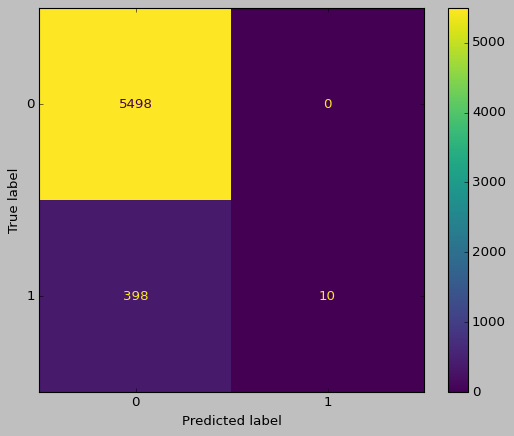

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.95
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [ ]:
y_pred = grid.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 95.43%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[5489    9]
 [ 261  147]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5498
           1       0.94      0.36      0.52       408

    accuracy                           0.95      5906
   macro avg       0.95      0.68      0.75      5906
weighted avg       0.95      0.95      0.94      5906



In [ ]:
import pickle

# Save the trained model
with open('hate_speech_model.pkl', 'wb') as model_file:
    pickle.dump(grid.best_estimator_, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vect, vectorizer_file)

print("Model and vectorizer saved!")


Model and vectorizer saved!


In [ ]:
import pickle
import re

# Simple tokenization approach (fallback)
def data_processing(tweet):
    tweet = re.sub(r'\W', ' ', tweet)  # Remove non-word characters
    tweet = tweet.lower()  # Convert to lowercase
    return tweet

def predict_hate_speech(tweet):
    # Load the model and vectorizer
    with open('hate_speech_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    print(f"Model loaded: {model}")

    with open('vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)
    print(f"Vectorizer loaded: {vectorizer}")

    # Preprocess and vectorize the input tweet
    tweet = data_processing(tweet)  # Process the tweet
    print(f"Processed tweet: {tweet}")
    tweet_vect = vectorizer.transform([tweet])

    # Predict
    prediction = model.predict(tweet_vect)
    prediction_proba = model.predict_proba(tweet_vect)
    print(f"Prediction: {prediction}")
    print(f"Prediction probabilities: {prediction_proba}")

    if prediction == 1:
        return "This is a Hate Speech Tweet!"
    else:
        return "This is a Non-Hate Speech Tweet!"

# Example usage
tweet = "bihday your majesty "
print(predict_hate_speech(tweet))


Model loaded: LogisticRegression(C=100)
Vectorizer loaded: TfidfVectorizer(ngram_range=(1, 3))
Processed tweet: bihday your majesty 
Prediction: [0]
Prediction probabilities: [[9.99895207e-01 1.04793340e-04]]
This is a Non-Hate Speech Tweet!


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
import pickle
import re

# Load the model and vectorizer
with open('hate_speech_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Simple tokenization approach (fallback)
def data_processing(tweet):
    tweet = re.sub(r'\W', ' ', tweet)  # Remove non-word characters
    tweet = tweet.lower()  # Convert to lowercase
    return tweet

# Function for prediction
def predict_hate_speech(tweet):
    # Preprocess and vectorize the input tweet
    tweet = data_processing(tweet)  # Process the tweet
    tweet_vect = vectorizer.transform([tweet])

    # Predict
    prediction = model.predict(tweet_vect)

    if prediction == 1:
        return "This is a Hate Speech Tweet!"
    else:
        return "This is a Non-Hate Speech Tweet!"

# Create a Gradio interface
iface = gr.Interface(fn=predict_hate_speech,
                     inputs="text",
                     outputs="text",
                     title="Hate Speech Detection",
                     description="Enter a tweet to check if it contains hate speech or not.")

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b27d86297f6531e5a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
